In [28]:
import toml
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pprint import pprint
from pathlib import Path
import re

graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

benchmark_dir = Path.cwd()
aster_gas_dir = benchmark_dir / "AsterGas"
collapsed_sticky_dir = benchmark_dir / "CollapsedStickyFilament"
confined_semiflex_dir = benchmark_dir / "ConfinedSemiFlexFilaments"

Text(0.5, 0, 'Threads')

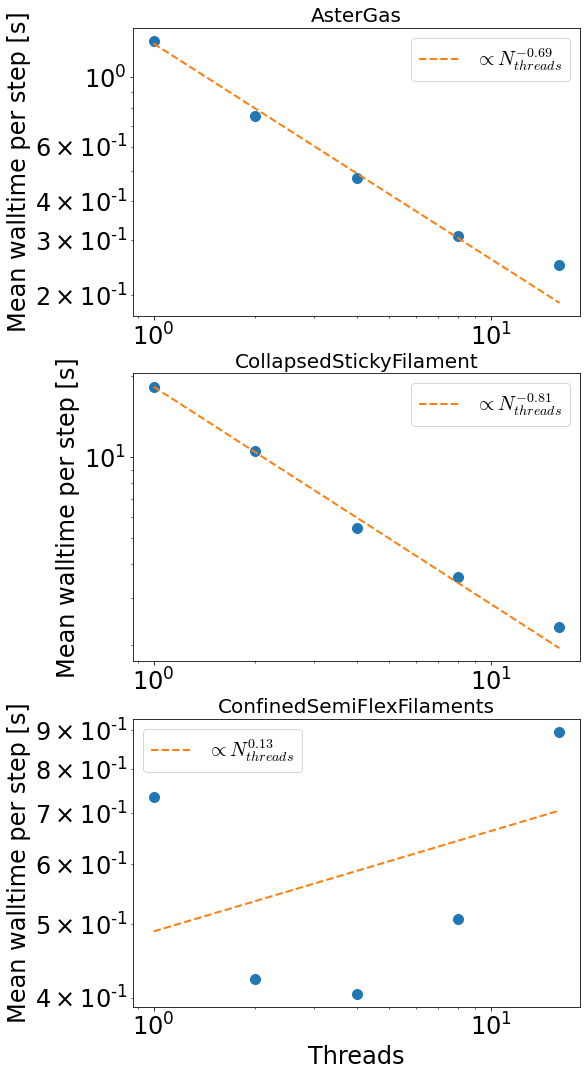

In [50]:
def extract_omp_num_threads(string):
    return int(re.search(r'OMP(\d+)', string).group(1))

def create_ordered_dict(toml_dict):
    return {k: toml_dict[k] for k in sorted(toml_dict, key=extract_omp_num_threads)}

def power_law(x, a, b):
    return a * x**b

def graph_walltime_vs_threads(benchmark_dir, ax):
    toml_dicts = {f.name:toml.load(f) for f in (benchmark_dir/'analysis').glob('*.toml')}
    toml_dicts = create_ordered_dict(toml_dicts)
    mean_walltime_per_step_list = []
    num_threads_list = []
    # pprint(toml_dicts)
    for k, v in toml_dicts.items():
        num_threads_list += [extract_omp_num_threads(k)]
        mean_walltime_per_step_list += [v['mean step walltime']]

    ax.loglog(num_threads_list, mean_walltime_per_step_list, 'o')
    popt, pcov = curve_fit(power_law, num_threads_list, mean_walltime_per_step_list, p0 = np.asarray([1.,-1]))
    ax.loglog(num_threads_list, power_law(num_threads_list, *popt), '--', label = r'$\propto N_{{threads}}^{{{:.2f}}}$'.format(popt[1]))
    ax.set_title(benchmark_dir.name)
    ax.legend()

fig, axarr = plt.subplots(3,1, figsize=(8, 18))

graph_walltime_vs_threads(aster_gas_dir, axarr[0])
graph_walltime_vs_threads(collapsed_sticky_dir, axarr[1])
graph_walltime_vs_threads(confined_semiflex_dir, axarr[2])


for ax in axarr:
    ax.set_ylabel(r'Mean walltime per step [s]')
axarr[-1].set_xlabel(r'Threads')


In [53]:
git_file = benchmark_dir / 'gitversion.txt'

with git_file.open('r') as f:
    _ = f.readline()
    _ = f.readline()

    git_version = f.readline().split()[-1].replace('"', '')
    build_timestamp = f.readline().split()[-1].replace('"', '')


toml_dicts = create_ordered_dict({f.name:toml.load(f) for f in (aster_gas_dir/'analysis').glob('*.toml')})
toml_summary_dict = {aster_gas_dir.name: {k: v['mean step walltime'] for k, v in toml_dicts.items()}}

toml_dicts = create_ordered_dict({f.name:toml.load(f) for f in (collapsed_sticky_dir/'analysis').glob('*.toml')})
toml_summary_dict[collapsed_sticky_dir.name] = {k: v['mean step walltime'] for k, v in toml_dicts.items()}

toml_dicts = create_ordered_dict({f.name:toml.load(f) for f in (confined_semiflex_dir/'analysis').glob('*.toml')})
toml_summary_dict[confined_semiflex_dir.name] = {k: v['mean step walltime'] for k, v in toml_dicts.items()}

benchmark_toml_file = benchmark_dir / f'{build_timestamp}_commit_{git_version}_benchmarking.toml'
with benchmark_toml_file.open('w') as f:
    f.write(toml.dumps(toml_summary_dict))


# Useful documenting functions

In [ ]:
# Save results in main benchmark directory
from datetime import date

# Get the current date as a string
current_date_str = date.today().isoformat()
print(current_date_str)

# Now 'current_date_str' is a string like '2022-03-14'

import subprocess

def get_current_git_commit():
    try:
        commit = subprocess.check_output(["git", "rev-parse", "HEAD"]).strip().decode('utf-8')
    except subprocess.CalledProcessError:
        commit = "Git not found"
    return commit

current_commit = get_current_git_commit()
print(current_commit)
